In [1]:
# https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api

'''

READ THIS PAPER!!
https://iopscience.iop.org/article/10.1088/1755-1315/615/1/012123/pdf
https://aaqr.org/articles/aaqr-20-05-oa-0257


'''

import glob
import ee
import pandas as pd

In [2]:
ee.Initialize()

In [3]:
from datetime import datetime
targets = glob.glob('data/epa/*.csv')



temp = pd.read_csv(targets[1])
temp = temp[temp['site_number'] == 40]
print(temp['date_local'])

0      2021-01-01
1      2021-01-01
2      2021-01-02
3      2021-01-02
4      2021-01-03
          ...    
725    2021-12-29
726    2021-12-30
727    2021-12-30
728    2021-12-31
729    2021-12-31
Name: date_local, Length: 730, dtype: object


In [4]:
lat, long = temp['latitude'][0], temp['longitude'][0]
i_date, f_date = min(temp['date_local']), max(temp['date_local'])

print(i_date, f_date)

temp['arithmetic_mean'] = temp['arithmetic_mean'] * 1.88 # converts to ug/m^3
temp['date_local'] = [datetime.strptime(temp['date_local'][i], '%Y-%m-%d') for i in range(len(temp))]

2021-01-01 2021-12-31


In [5]:
temp['arithmetic_mean']

0      24.390956
1      24.390956
2      18.533666
3      18.533666
4      24.259834
         ...    
725    34.641044
726    38.278436
727    38.278436
728    26.311826
729    26.311826
Name: arithmetic_mean, Length: 730, dtype: float64

In [6]:
'''
AQI: sulphur dioxide, nitrogen dioxide, PM2.5, ozone, and carbon monoxide

PM2.5 is going to be trickier than the other ones. Read this paper: https://link.springer.com/article/10.1007/s40726-020-00170-4#Sec11

https://arxiv.org/abs/1709.05912
1km AOD from MODIS: https://ieeexplore.ieee.org/document/1522625
'''

# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

# Aerosol Data: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_AER_AI#bands
aai = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_AER_AI") 

# Weather Data: https://developers.google.com/earth-engine/datasets/catalog/NOAA_CFSR#bands
weather = ee.ImageCollection("NOAA/CFSR")


'''
    Gas Datasets
'''

# Import Sentinel-5 Ozone data: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_O3#bands
# R = 1113.2 meters 
ozone = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_O3")

# Import Sentinel-5 NO2 data: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_NO2
# R = 1113.2 meters 
no2 = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") 

# Import Sentinel-5 SO2 data: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_SO2
# R = 1113.2 meters
so2 = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_SO2")

# Import Sentinel-5 CO data: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_CO
# R = 1113.2 meters
co = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_CO")

In [7]:
# Initial date of interest (inclusive).
#i_date = '2017-01-01'

# Final date of interest (exclusive).
#f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
ozone = ozone.select('O3_column_number_density').filterDate(i_date, f_date)
no2 = no2.select('NO2_column_number_density').filterDate(i_date, f_date)
so2 = so2.select('SO2_column_number_density').filterDate(i_date, f_date)
co = co.select('CO_column_number_density').filterDate(i_date, f_date)

weather = weather.select('u-component_of_wind_hybrid', 'v-component_of_wind_hybrid', 'Pressure_surface', 'Precipitable_water_entire_atmosphere_single_layer', \
                         'Planetary_Boundary_Layer_Height_surface', 'Relative_humidity_entire_atmosphere_single_layer').filterDate(i_date, f_date)

In [8]:
# Define the urban location of interest as a point near Lyon, France.
#u_lon = 4.8148
#u_lat = 45.7758
u_poi = ee.Geometry.Point(long, lat)
scale = 1000

In [9]:
# Get the data for the pixel intersecting the point in urban area.
no2_column = no2.getRegion(u_poi, scale).getInfo()
ozone_column = ozone.getRegion(u_poi, scale).getInfo()
so2_column = so2.getRegion(u_poi, scale).getInfo()
co_column = co.getRegion(u_poi, scale).getInfo()

# Preview the result.
co_column[:5]

[['id', 'longitude', 'latitude', 'time', 'CO_column_number_density'],
 ['20210101T175005_20210101T182044',
  -76.6038358532922,
  39.29680210380847,
  1609523399000,
  None],
 ['20210102T173005_20210102T180125',
  -76.6038358532922,
  39.29680210380847,
  1609608599000,
  None],
 ['20210102T191005_20210102T194121',
  -76.6038358532922,
  39.29680210380847,
  1609614600000,
  None],
 ['20210103T171005_20210103T174251',
  -76.6038358532922,
  39.29680210380847,
  1609693799000,
  None]]

In [10]:
weather_data = weather.getRegion(u_poi, scale).getInfo()

In [11]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [12]:
no2_column = ee_array_to_df(no2_column,['NO2_column_number_density'])
so2_column = ee_array_to_df(so2_column,['SO2_column_number_density'])
ozone_column = ee_array_to_df(ozone_column,['O3_column_number_density'])
co_column = ee_array_to_df(co_column,['CO_column_number_density'])

weather_data = ee_array_to_df(weather_data, ['u-component_of_wind_hybrid', 'v-component_of_wind_hybrid', 'Pressure_surface', 'Precipitable_water_entire_atmosphere_single_layer', \
                         'Planetary_Boundary_Layer_Height_surface', 'Relative_humidity_entire_atmosphere_single_layer'])

no2_column.head()

,time,datetime,NO2_column_number_density
1,1609608599000,2021-01-02 17:29:59,0.000121
9,1610041128000,2021-01-07 17:38:48,0.000130
12,1610211528000,2021-01-09 16:58:48,0.000092
13,1610217528000,2021-01-09 18:38:48,0.000099
16,1610302728000,2021-01-10 18:18:48,0.000109


In [13]:
weather_data.head()

,time,datetime,u-component_of_wind_hybrid,v-component_of_wind_hybrid,Pressure_surface,Precipitable_water_entire_atmosphere_single_layer,Planetary_Boundary_Layer_Height_surface,Relative_humidity_entire_atmosphere_single_layer
0,1609459200000,2021-01-01 00:00:00,0.62,-2.88,101350,17.299999,668,32
1,1609459200000,2021-01-01 00:00:00,0.03,-3.34,101440,9.600000,326,16
2,1609480800000,2021-01-01 06:00:00,-0.26,-3.03,101730,7.000000,243,13
3,1609480800000,2021-01-01 06:00:00,-1.61,-2.23,101600,7.300000,174,13
4,1609502400000,2021-01-01 12:00:00,-1.74,-2.33,101880,11.800000,294,22


In [14]:
dat1 = pd.merge_asof(no2_column, so2_column, on="datetime", direction='nearest', tolerance=pd.Timedelta(1, 'd'))
dat1 = dat1.drop(['time_y'], axis = 1)
dat1 = dat1.rename(columns={'time_x': 'time'})

dat2 = pd.merge_asof(dat1, ozone_column, on="datetime", direction='nearest', tolerance=pd.Timedelta(1, 'd'))
dat2 = dat2.drop(['time_y'], axis = 1)
dat2 = dat2.rename(columns={'time_x': 'time'})

dat = pd.merge_asof(dat2, co_column, on="datetime", direction='nearest', tolerance=pd.Timedelta(1, 'd'))
dat = dat.drop(['time_y'], axis = 1)
dat = dat.rename(columns={'time_x': 'time'})

dat = pd.merge_asof(dat, weather_data, on="datetime", direction='nearest', tolerance=pd.Timedelta(1, 'd'))
dat = dat.drop(['time_y'], axis = 1)
dat = dat.rename(columns={'time_x': 'time'})

In [15]:
dat[5:10]

,time,datetime,NO2_column_number_density,SO2_column_number_density,O3_column_number_density,CO_column_number_density,u-component_of_wind_hybrid,v-component_of_wind_hybrid,Pressure_surface,Precipitable_water_entire_atmosphere_single_layer,Planetary_Boundary_Layer_Height_surface,Relative_humidity_entire_atmosphere_single_layer
5,1610473428000,2021-01-12 17:43:48,0.000180,NaN,0.148311,0.037847,1.11,-0.87,100650,4.8,735,13
6,1610558629000,2021-01-13 17:23:49,0.000283,NaN,0.161941,0.042636,1.57,1.27,100230,8.5,1001,23
7,1610564628000,2021-01-13 19:03:48,0.000464,NaN,0.163142,0.042636,0.07,2.44,100050,9.9,320,26
8,1610735307000,2021-01-15 18:28:27,0.000121,NaN,0.157008,NaN,-3.93,3.49,99420,14.3,896,35
9,1610905646000,2021-01-17 17:47:26,0.000095,NaN,0.157060,0.038867,4.27,0.41,99310,8.7,1638,28


In [16]:
temp['date_local']

0     2021-01-01
1     2021-01-01
2     2021-01-02
3     2021-01-02
4     2021-01-03
         ...    
725   2021-12-29
726   2021-12-30
727   2021-12-30
728   2021-12-31
729   2021-12-31
Name: date_local, Length: 730, dtype: datetime64[ns]

(0.0, 40.0)

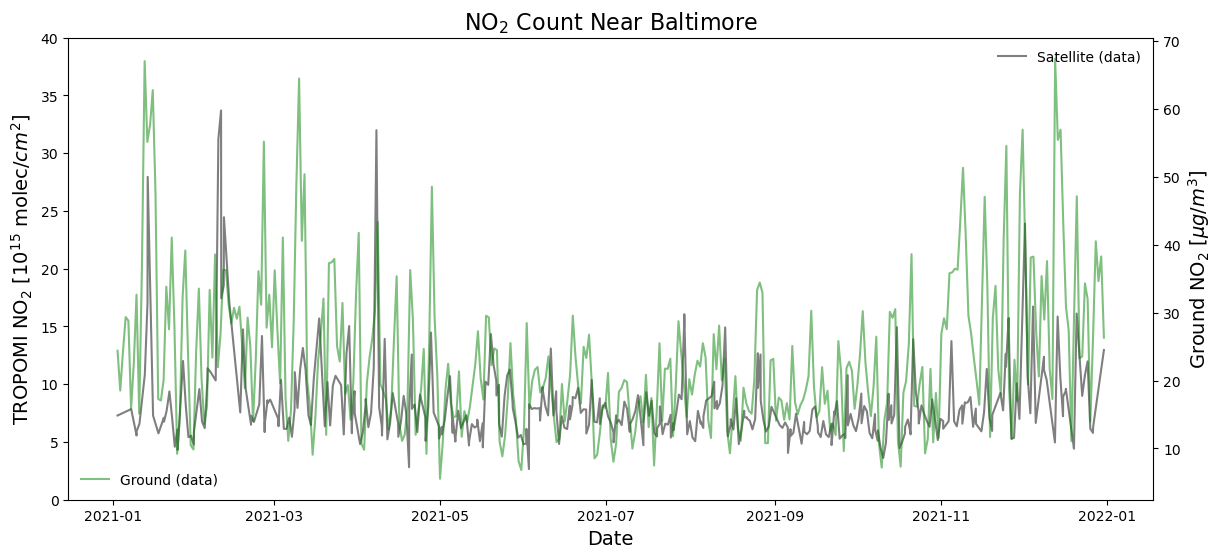

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))


# Add scatter plots.
lns1 = ax.plot(dat['datetime'], dat['NO2_column_number_density'] * 1e-4 * 6.022e23 * 1e-15, c='black', alpha=0.5, label='Satellite (data)')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel(r'TROPOMI NO$_2$ $[10^{15}$ molec$/cm^2]$', fontsize=14)
ax.set_title(r'NO$_2$ Count Near Baltimore', fontsize=16)

ax2=fig.add_subplot(111, label="2", frame_on=False)

lns2 = ax2.plot(temp['date_local'], temp['arithmetic_mean'], c='green', alpha=0.5, label='Ground (data)')
ax2.set_ylabel(r'Ground NO$_2$ $[\mu g/m^3]$', fontsize=14)
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='y', colors=p2.get_color(), labelsize=14)

# Add some parameters.

ax.legend(framealpha = 0)
ax2.legend(framealpha = 0)

ax.set_ylim(-0, 40)
#ax.grid(lw=0.2)



In [18]:
print(dat['datetime'])
#type(temp['date_local'][0])

0     2021-01-02 17:29:59
1     2021-01-07 17:38:48
2     2021-01-09 16:58:48
3     2021-01-09 18:38:48
4     2021-01-10 18:18:48
              ...        
424   2021-12-24 17:57:39
425   2021-12-25 17:37:39
426   2021-12-26 17:17:39
427   2021-12-26 18:57:39
428   2021-12-30 17:42:39
Name: datetime, Length: 429, dtype: datetime64[ns]


In [19]:
dat = pd.merge_asof(dat, temp, left_on="datetime", right_on="date_local", direction='nearest', tolerance=pd.Timedelta(1, 'd'), suffixes = ('', ''))
#dat = dat.drop(['time_y'], axis = 1)
#dat = dat.rename(columns={'time_x': 'time'})

In [20]:
dat['NO2_column_number_density']

0      0.000121
1      0.000130
2      0.000092
3      0.000099
4      0.000109
         ...   
424    0.000199
425    0.000102
426    0.000096
427    0.000105
428    0.000215
Name: NO2_column_number_density, Length: 429, dtype: float64

(0.0, 40.0)

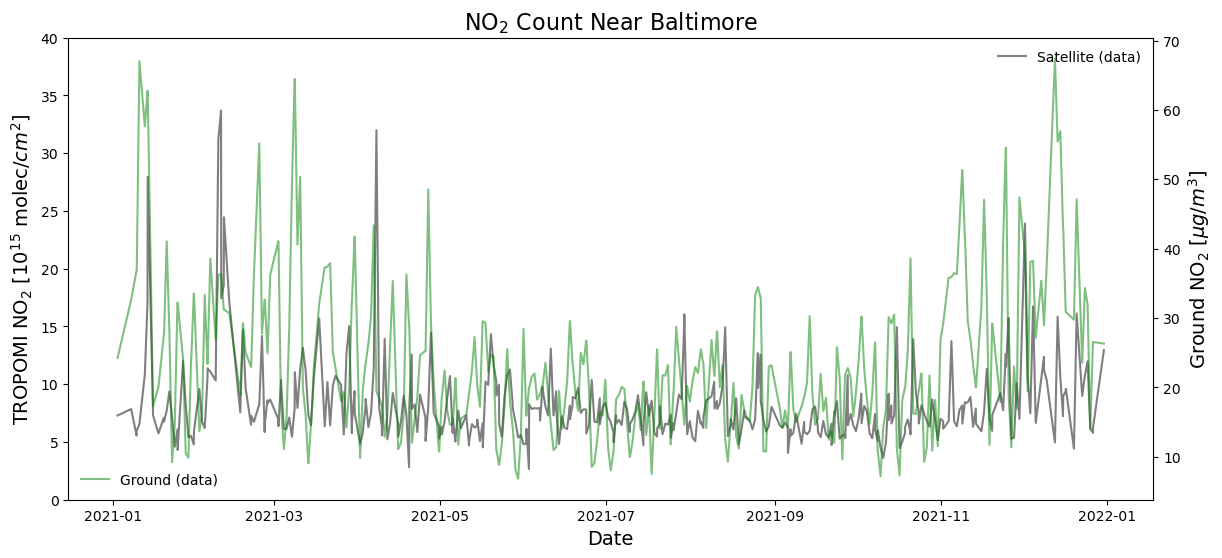

In [21]:
# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))


# Add scatter plots.
lns1 = ax.plot(dat['datetime'], dat['NO2_column_number_density'] * 1e-4 * 6.022e23 * 1e-15, c='black', alpha=0.5, label='Satellite (data)')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel(r'TROPOMI NO$_2$ $[10^{15}$ molec$/cm^2]$', fontsize=14)
ax.set_title(r'NO$_2$ Count Near Baltimore', fontsize=16)

ax2=fig.add_subplot(111, label="2", frame_on=False)

lns2 = ax2.plot(dat['datetime'], dat['arithmetic_mean'], c='green', alpha=0.5, label='Ground (data)')
ax2.set_ylabel(r'Ground NO$_2$ $[\mu g/m^3]$', fontsize=14)
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right') 
#ax2.tick_params(axis='y', colors=p2.get_color(), labelsize=14)

# Add some parameters.

ax.legend(framealpha = 0)
ax2.legend(framealpha = 0)

ax.set_ylim(-0, 40)
#ax.grid(lw=0.2)

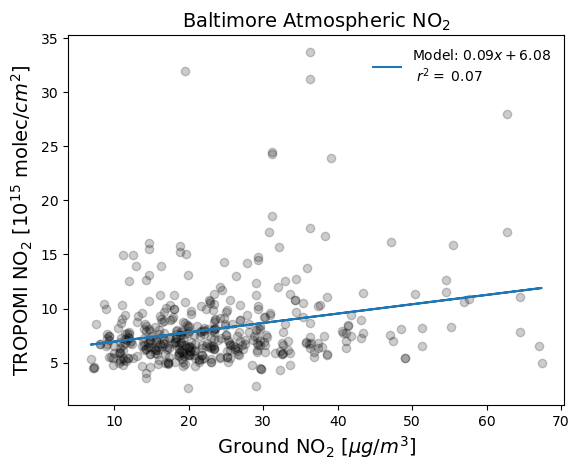

In [22]:
from scipy import stats

m, b, r, p, se = stats.linregress(dat['arithmetic_mean'], dat['NO2_column_number_density'] * 1e-4 * 6.022e23 * 1e-15)


plt.scatter(dat['arithmetic_mean'], dat['NO2_column_number_density'] * 1e-4 * 6.022e23 * 1e-15, c='black', alpha=0.2)
plt.plot(dat['arithmetic_mean'], m*dat['arithmetic_mean'] + b, label = 'Model: {:2.2f}$x+${:2.2f} \n $r^2 =$ {:2.2f}'.format(m, b, r**2))
plt.xlabel(r'Ground NO$_2$ $[\mu g/m^3]$', fontsize=14)
plt.ylabel(r'TROPOMI NO$_2$ $[10^{15}$ molec$/cm^2]$', fontsize=14)
plt.title('Baltimore Atmospheric NO$_2$', fontsize = 14)

#plt.grid(lw=0.2)
plt.legend(framealpha = 0)